In [1]:
import numpy as np
import os
import cv2
import h5py
import struct
import vtk
import vtk.util
#import cntk as C
from vtk.util import numpy_support
import matplotlib.pyplot as plt
from volume_extraction import *
from utilities import *
from VTKFunctions import *
from scipy.ndimage import affine_transform, rotate, zoom, shift
#from joblib import Parallel, delayed

from ipywidgets import FloatProgress
from IPython.display import display

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# segmentation volume size should be 448x448x512.
# Input data should be 448x448xZ
def CNTKSegmentation(data, path):
    z = C.load_model(path)
    maskarray = np.zeros(data.shape)
    
    for i in range(data.shape[1]):
        sliced = (data[:, i, 50:562] - 113.05652141)/39.87462853
        #sliced = np.swapaxes(sliced,0,1)
        sliced = np.ascontiguousarray(sliced,dtype=np.float32)
        mask = z.eval(sliced.reshape(1,sliced.shape[0],sliced.shape[1]))
        maskarray[:, i, 50:562] = mask[0].squeeze()
    return maskarray

def Pipeline(path, sample, savepath, threshold, size, maskpath = None, modelpath = None):
    
    # Load sample
    print('Sample name: ' + sample)
    print('1. Load sample')
    data = None
    data, bounds = Load(path)
    PrintOrthogonal(data)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_input.png", data)
    if maskpath != None and modelpath == None:
        print(maskpath)
        mask, _ = Load(maskpath)
        PrintOrthogonal(mask)
        
    # Orient array
    print('2. Orient sample')
    data, angles = Orient(data, bounds)
    PrintOrthogonal(data)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_orient.png", data)
    if maskpath != None and modelpath == None:
        mask = OrientMask(mask, angles)
        
    # Flip and crop volume
    print('3. Crop and flip center volume:')
    data, crop = CropCenter(data, threshold, size[0])
    data = np.flip(data, 2)
    PrintOrthogonal(data)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_orient_cropped.png", data)
    if maskpath != None and modelpath == None:
        mask = mask[crop[0]:crop[1], crop[2]:crop[3], :]
        mask = np.flip(mask, 2)
        PrintOrthogonal(mask)
    if modelpath != None:
        mask = CNTKSegmentation(data, modelpath)
        PrintOrthogonal(mask)
        SaveOrthogonal(savepath + "\\Images\\" + sample + "_mask.png", mask)

    ## Crop to 400x400
    #data = data[24:-24, 24:-24, :]
    #mask = mask[24:-24, 24:-24, :]
    #size[0] = 400
    #print(data.shape)
       
    # Get VOIs
    print('4. Get interface coordinates:')
    surfvoi, interface = GetInterface(data, threshold, size, 'surface', None)
    PrintOrthogonal(surfvoi)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_surface.png", surfvoi)
    if maskpath != None and len(size) == 2:
        print('Offset parameter not given. Setting offset to 0.')
        size.append(0)
    if maskpath != None: # Input offset for size[2] to give voi offset from mask interface
        print("Data shape : {0},{1},{2}".format(data.shape[0],data.shape[1],data.shape[2]))
        print("Mask shape : {0},{1},{2}".format(mask.shape[0],mask.shape[1],mask.shape[2]))
        deepvoi, ccvoi, interface = GetInterface(data, threshold, size, 'bci', (mask>0.7))
        PrintOrthogonal(deepvoi)
        SaveOrthogonal(savepath + "\\Images\\" + sample + "_deep.png", deepvoi)
        PrintOrthogonal(ccvoi)
        SaveOrthogonal(savepath + "\\Images\\" + sample + "_cc.png", ccvoi)
    
    # Calculate mean and std
    print('5. Save mean and std images')
    mean = np.mean(surfvoi, 2)
    std = np.std(surfvoi, 2)
    plt.imshow(mean); plt.show()
    plt.imshow(std); plt.show()
    # Save
    cv2.imwrite(savepath + "\\Images\\" + sample + "_surface_mean.png", 
                ((mean - np.min(mean)) / (np.max(mean) - np.min(mean)) * 255))
    cv2.imwrite(savepath + "\\Images\\" + sample + "_surface_std.png",
                ((std - np.min(std)) / (np.max(std) - np.min(std)) * 255))
    writebinaryimage(savepath + "\\Surface\\" + sample + '_surface_mean.dat', mean, 'double')
    writebinaryimage(savepath + "\\Surface\\" + sample + '_surface_std.dat', std, 'double')
    if maskpath != None:
        mean = np.mean(deepvoi, 2)
        std = np.std(deepvoi, 2)
        plt.imshow(mean); plt.show()
        plt.imshow(std); plt.show()
        cv2.imwrite(savepath + "\\Images\\" + sample + "_deep_mean.png", 
                ((mean - np.min(mean)) / (np.max(mean) - np.min(mean)) * 255))
        cv2.imwrite(savepath + "\\Images\\" + sample + "_deep_std.png",
                ((std - np.min(std)) / (np.max(std) - np.min(std)) * 255))
        writebinaryimage(savepath + "\\Deep\\" + sample + '_deep_mean.dat', mean, 'double')
        writebinaryimage(savepath + "\\Deep\\" + sample + '_deep_std.dat', std, 'double')
        mean = np.mean(ccvoi, 2)
        std = np.std(ccvoi, 2)
        plt.imshow(mean); plt.show()
        plt.imshow(std); plt.show()
        cv2.imwrite(savepath + "\\Images\\" + sample + "_cc_mean.png", 
                ((mean - np.min(mean)) / (np.max(mean) - np.min(mean)) * 255))
        cv2.imwrite(savepath + "\\Images\\" + sample + "_cc_std.png",
                ((std - np.min(std)) / (np.max(std) - np.min(std)) * 255))
        writebinaryimage(savepath + "\\Calcified\\" + sample + '_cc_mean.dat', mean, 'double')
        writebinaryimage(savepath + "\\Calcified\\" + sample + '_cc_std.dat', std, 'double')
      

### Full pipeline for all samples

In [ ]:
# Parameters
impath = r"Z:\3DHistoData\rekisteroidyt"
modelpath = r"Z:\Tuomas\UNetNew.model"
savepath = r"Z:\3DHistoData\SurfaceImages - revised"
sample = '15_L6TL_2'
threshold = 80
size = [448, 40, 10] # width, depth, offset

# List directories
files = os.listdir(impath)
files.sort()
print(files)

for k in range(2 + 15 * 4, len(files), 4): # Skip 1 CA4+ file and 2 .zip files
#for k in range(2, len(files), 4): # Skip 1 CA4+ file and 2 .zip files
    try:
        file = os.listdir(impath + "\\" + files[k] + "\\" + "Registration" )
        pth = impath + "\\" + files[k] + "\\" + "Registration"
    except FileNotFoundError: # Case: sample name folder twice
        try:
            file = os.listdir(impath + "\\" + files[k] + "\\" + files[k] + "\\" + "Registration" )
            pth = impath + "\\" + files[k] + "\\" + files[k] + "\\" + "Registration"
        except FileNotFoundError: # Case: Unusable folder
            cotinue
    try:
        file = os.listdir(impath + "\\" + files[k - 2] + "\\Suoristettu\\Registration\\bone_mask" )
        maskpath = impath + "\\" + files[k - 2] + "\\Suoristettu\\Registration\\bone_mask"
    except FileNotFoundError: # Case: sample name folder twice
        try:
            file = os.listdir(impath + "\\" + files[k - 2] + "\\" + files[k - 2] + "\\Suoristettu\\Registration\\bone_mask" )
            maskpath = impath + "\\" + files[k - 2] + "\\" + files[k - 2] + "\\Suoristettu\\Registration\\bone_mask"
        except FileNotFoundError: # Case: Unusable folder
            continue
    # Leave maskpath empty, since mask is segmented from samples
    print(pth)
    print(maskpath)
    # Pipeline with loaded mask
    Pipeline(pth, files[k], savepath, threshold, size, maskpath, None)
    # Pipeline with CNTK model
    #Pipeline(pth, files[k], savepath, threshold, size, None, modelpath)

['13_R3L_2_CA4+_Rec', '13_R3L_2_CA4+_Rec.zip', '13_R3L_2_PTA_48h_Rec', '13_R3L_2_PTA_48h_Rec.zip', '13_R6TL_2_CA4+_Rec', '13_R6TL_2_CA4+_Rec.zip', '13_R6TL_2_PTA_48h_Rec', '13_R6TL_2_PTA_48h_Rec.zip', '14_R3L_2_CA4+_Rec', '14_R3L_2_CA4+_Rec.zip', '14_R3L_2_PTA_48h_Rec', '14_R3L_2_PTA_48h_Rec.zip', '14_R6LT_2_CA4+_Rec', '14_R6LT_2_CA4+_Rec.zip', '14_R6LT_2_PTA_48h_Rec', '14_R6LT_2_PTA_48h_Rec.zip', '15_L3L_2_CA4+_Rec', '15_L3L_2_CA4+_Rec.zip', '15_L3L_2_PTA_48h_Rec', '15_L3L_2_PTA_48h_Rec.zip', '15_L6TL_2_CA4+_Rec', '15_L6TL_2_CA4+_Rec.zip', '15_L6TL_2_PTA_48h_Rec', '15_L6TL_2_PTA_48h_Rec.zip', '20_R2M_2_CA4+_Rec', '20_R2M_2_CA4+_Rec.zip', '20_R2M_2_PTA_48h_Rec', '20_R2M_2_PTA_48h_Rec.zip', '20_R6TM_2_CA4+_Rec', '20_R6TM_2_CA4+_Rec.zip', '20_R6TM_2_PTA_48h_Rec', '20_R6TM_2_PTA_48h_Rec.zip', '21_L3L_2_CA4+_Rec', '21_L3L_2_CA4+_Rec.zip', '21_L3L_2_PTA_48h_Rec', '21_L3L_2_PTA_48h_Rec.zip', '21_L6LT_1_CA4+_Rec', '21_L6LT_1_CA4+_Rec.zip', '21_L6LT_1_PTA_48h_Rec', '21_L6LT_1_PTA_48h_Rec.zip',

FloatProgress(value=0.0, description='Loading:', max=1883.0)

### Individual sample pipeline

Sample name: 15_L6TL_2
1. Load sample


FloatProgress(value=0.0, description='Loading:', max=574.0)

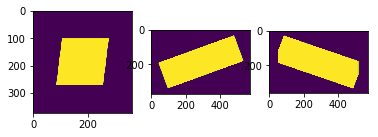

Z:\3DHistoData\Test data\Cube


FloatProgress(value=0.0, description='Loading:', max=574.0)

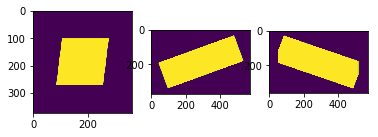

2. Orient sample


FloatProgress(value=0.0, description='Orienting:')

[[70.31990757]]
[[110.00257612]]
angles: [-27.604902], [21.052917], [-19.865988], [20.416368]
pca angles: [[-19.68009243]], [[20.00257612]]


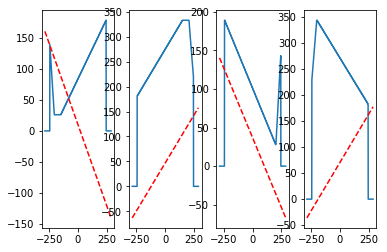

Angle 1: [[-19.68009243]]
Angle 2: [[20.00257612]]


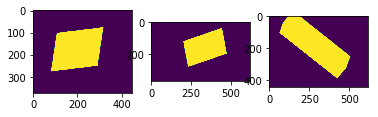

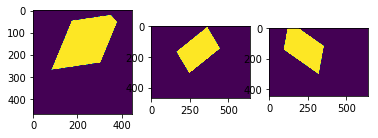

FloatProgress(value=0.0, description='Rotate mask:')

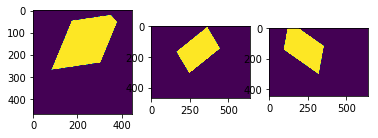

3. Crop and flip center volume:


FloatProgress(value=0.0, description='Get center:', max=467.0)

<class 'numpy.float64'>


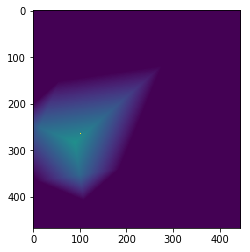

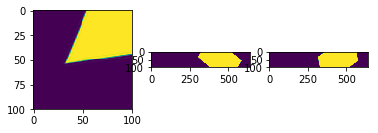

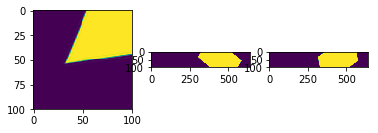

4. Get interface coordinates:


FloatProgress(value=0.0, description='Get interface:')

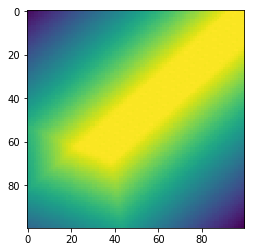

interface dims: 100,100


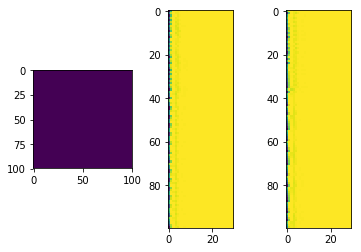

Data shape : 100,100,641
Mask shape : 100,100,641


FloatProgress(value=0.0, description='Get interface:')

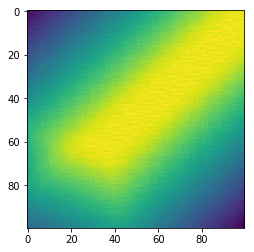

interface dims: 100,100


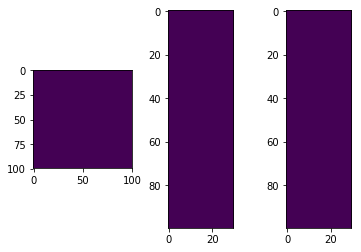

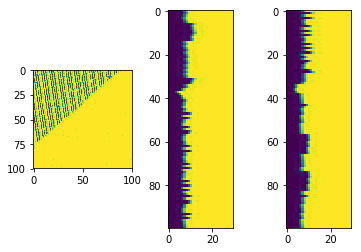

5. Save mean and std images


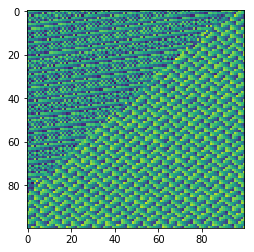

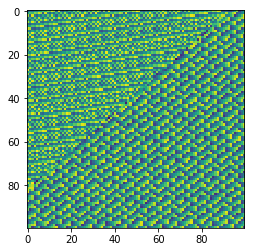

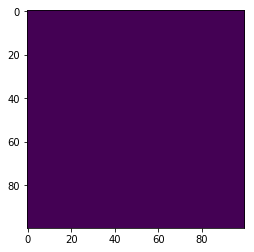

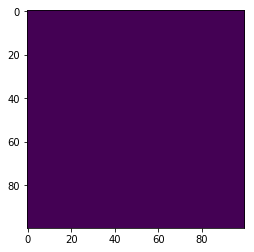

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide


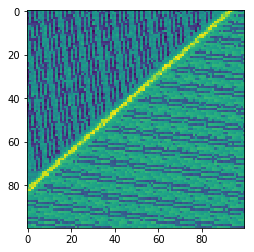

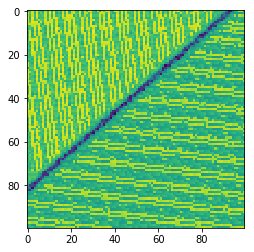

In [5]:
# Pipeline for binned sample and loaded mask
#path = r"Z:\3DHistoData\Test data\21_L3L_binned"
#path = r"Z:\3DHistoData\Test data\24_R6LT_2_binned"
#mask = r"Z:\3DHistoData\Test data\21_L3L_binned\bonemask"
#path = r"Z:\3DHistoData\rekisteroidyt\24_R6LT_2_PTA_48h_Rec\24_R6LT_2_PTA_48h_Rec\Registration"
#mask = r"Z:\3DHistoData\rekisteroidyt\24_R6LT_2_CA4+_Rec\24_R6LT_2_CA4+_Rec\Suoristettu\Registration\bone_mask"
path = r'Z:\3DHistoData\Test data\Cube'
mask = r'Z:\3DHistoData\Test data\Cube'
savepath = r"Z:\3DHistoData\SurfaceImages"
modelpath = r"Z:\Tuomas\cntkunet.model"
sample = '15_L6TL_2'
threshold = 80
size = [100, 30, 3] # width, depth, bci offset

Pipeline(path, sample, savepath, threshold, size, mask)

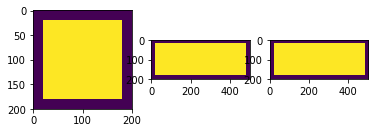

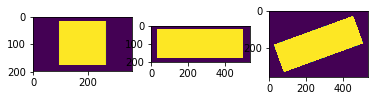

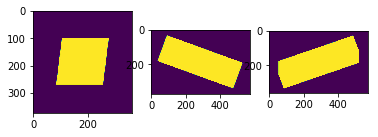

In [9]:
from scipy.ndimage.interpolation import rotate
savepath = r'Z:\3DHistoData\Test data\Cube2'
test = np.uint8(np.zeros((200,200,500)))
test[20:-20,20:-20,20:-20] = 255
PrintOrthogonal(test)

RenderVolume(test)
test = rotate(test, 20, (1,2))
PrintOrthogonal(test)
test = rotate(test, -20, (0,2))
PrintOrthogonal(test)

#xangle = RotationMatrix(np.pi/4, 0)
#yangle = RotationMatrix(-np.pi/4, 1)
#test = affine_transform(test, xangle)
#test = affine_transform(test, yangle)

Save(savepath, 'Rotated_Cube', test)
RenderVolume(test)

Sample name: 15_L6TL_2
1. Load sample


FloatProgress(value=0.0, description='Loading:', max=625.0)

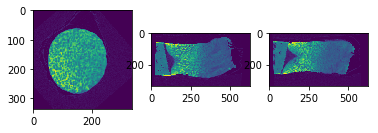

Z:\3DHistoData\Test data\21_L3L_binned\bonemask


FloatProgress(value=0.0, description='Loading:', max=370.0)

(336, 336, 370)


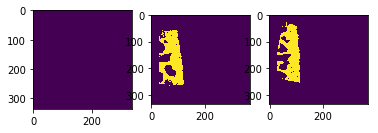

2. Orient sample


FloatProgress(value=0.0, description='Orienting:')

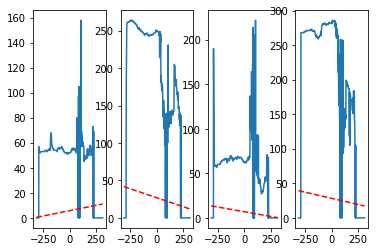

Angle 1: [-0.88682806]
Angle 2: [-1.619218]


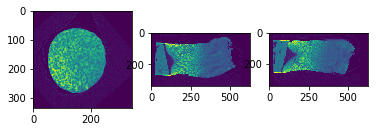

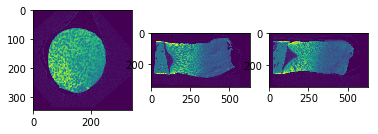

FloatProgress(value=0.0, description='Rotate mask:')

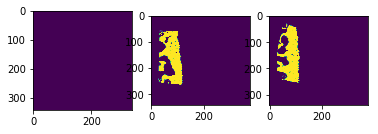

3. Crop and flip center volume:


FloatProgress(value=0.0, description='Get center:', max=345.0)

<class 'numpy.float64'>


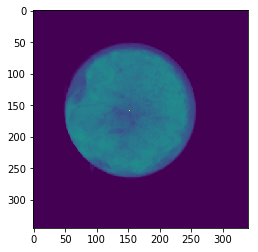

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))
C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))


IndexError: index 0 is out of bounds for axis 1 with size 0

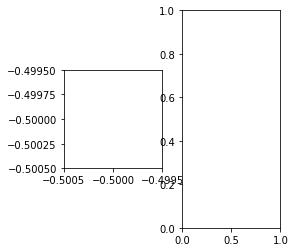

In [6]:
# Parameters
#path = r"Z:\3DHistoData\rekisteroidyt\24_R6LT_2_PTA_48h_Rec\24_R6LT_2_PTA_48h_Rec\Registration"
#mask = r"Z:\3DHistoData\rekisteroidyt\24_R6LT_2_CA4+_Rec\24_R6LT_2_CA4+_Rec\Suoristettu\Registration\bone_mask"
path = r"Z:\3DHistoData\Test data\24_R6LT_2_binned"
maskpath = r"Z:\3DHistoData\Test data\21_L3L_binned\bonemask"
savepath = r"Z:\3DHistoData\SurfaceImages"
modelpath = r"Z:\Tuomas\cntkunet.model"
sample = '15_L6TL_2'
modelpath = None
threshold = 80
size = [448, 40, 10] # width, depth, offset

print('Sample name: ' + sample)
print('1. Load sample')
data, bounds = Load(path)
PrintOrthogonal(data)
SaveOrthogonal(savepath + "\\Images\\" + sample + "_input.png", data)
if maskpath != None and modelpath == None:
    print(maskpath)
    mask, _ = Load(maskpath)
    print(np.shape(mask))
    PrintOrthogonal(mask)

RenderVolume(data)
# Orient array
print('2. Orient sample')
data, angles = Orient(data, bounds)
PrintOrthogonal(data)
SaveOrthogonal(savepath + "\\Images\\" + sample + "_orient.png", data)
if maskpath != None and modelpath == None:
    mask = OrientMask(mask, angles)
    orientedmask = mask

# Flip and crop volume
print('3. Crop and flip center volume:')
data, crop = CropCenter(data, threshold, size[0])
data = np.flip(data, 2)
PrintOrthogonal(data)
SaveOrthogonal(savepath + "\\Images\\" + sample + "_orient_cropped.png", data)
if maskpath != None and modelpath == None:
    mask = mask[crop[0]:crop[1], crop[2]:crop[3], :]
    mask = np.flip(mask, 2)
    PrintOrthogonal(mask)
if modelpath != None:
    mask = CNTKSegmentation(data, modelpath)
    PrintOrthogonal(mask)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_mask.png", mask)
    
# Crop to 400x400
data = data[24:-24, 24:-24, :]
mask = mask[24:-24, 24:-24, :]
size[0] = 400
print(data.shape)

# Get VOIs
print('4. Get interface coordinates:')
surfvoi, interface = GetInterface(data, threshold, size, 'surface', None)
PrintOrthogonal(surfvoi)
SaveOrthogonal(savepath + "\\Images\\" + sample + "_surface.png", surfvoi)
if maskpath != None and len(size) == 2:
    print('Offset parameter not given. Setting offset to 0.')
    size.append(0)
if maskpath != None: # Input offset for size[2] to give voi offset from mask interface
    print("Data shape : {0},{1},{2}".format(data.shape[0],data.shape[1],data.shape[2]))
    print("Mask shape : {0},{1},{2}".format(mask.shape[0],mask.shape[1],mask.shape[2]))
    deepvoi, ccvoi, interface = GetInterface(data, threshold, size, 'bci', (mask>0.7))
    PrintOrthogonal(deepvoi)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_deep.png", deepvoi)
    PrintOrthogonal(ccvoi)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_cc.png", ccvoi)

# Calculate mean and std 
print('5. Save mean and std images')
mean = np.mean(surfvoi, 2)
std = np.std(surfvoi, 2)
plt.imshow(mean); plt.show()
plt.imshow(std); plt.show()
# Save
cv2.imwrite(savepath + "\\Images\\" + sample + "_surface_mean.png", 
            ((mean - np.min(mean)) / (np.max(mean) - np.min(mean)) * 255))
cv2.imwrite(savepath + "\\Images\\" + sample + "_surface_std.png",
            ((std - np.min(std)) / (np.max(std) - np.min(std)) * 255))
writebinaryimage(savepath + "\\Surface\\" + sample + '_surface_mean.dat', mean, 'double')
writebinaryimage(savepath + "\\Surface\\" + sample + '_surface_std.dat', std, 'double')
if maskpath != None:
    mean = np.mean(deepvoi, 2)
    std = np.std(deepvoi, 2)
    plt.imshow(mean); plt.show()
    plt.imshow(std); plt.show()
    cv2.imwrite(savepath + "\\Images\\" + sample + "_deep_mean.png", 
            ((mean - np.min(mean)) / (np.max(mean) - np.min(mean)) * 255))
    cv2.imwrite(savepath + "\\Images\\" + sample + "_deep_std.png",
            ((std - np.min(std)) / (np.max(std) - np.min(std)) * 255))
    writebinaryimage(savepath + "\\Deep\\" + sample + '_deep_mean.dat', mean, 'double')
    writebinaryimage(savepath + "\\Deep\\" + sample + '_deep_std.dat', std, 'double')
    mean = np.mean(ccvoi, 2)
    std = np.std(ccvoi, 2)
    plt.imshow(mean); plt.show()
    plt.imshow(std); plt.show()
    cv2.imwrite(savepath + "\\Images\\" + sample + "_cc_mean.png", 
            ((mean - np.min(mean)) / (np.max(mean) - np.min(mean)) * 255))
    cv2.imwrite(savepath + "\\Images\\" + sample + "_cc_std.png",
            ((std - np.min(std)) / (np.max(std) - np.min(std)) * 255))
    writebinaryimage(savepath + "\\Calcified\\" + sample + '_cc_mean.dat', mean, 'double')
    writebinaryimage(savepath + "\\Calcified\\" + sample + '_cc_std.dat', std, 'double')

### VTK rendering

FloatProgress(value=0.0, description='Loading:', max=1260.0)

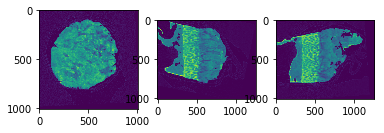

In [35]:
# Load and render
path = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\21_L3L_binned"
path = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\15_L6TL_2_PTA_48h_Rec\Registration"
mask = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\21_L3L_binned\bonemask"
data, bounds = Load(path)
PrintOrthogonal(data)
RenderVolume(data)

### VTK processing

In [ ]:
def ArrayToVTK(A):
    imagedata = vtk.vtkImageData()
    depthArray = numpy_support.numpy_to_vtk(A.ravel(), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
    imagedata.SetDimensions(A.shape)
    imagedata.SetOrigin(0,0,0)
    imagedata.GetPointData().SetScalars(depthArray)
    return imagedata

def VTKToArray(vtkdata, shape):
    array = numpy_support.vtk_to_numpy(vtkdata)
    array = array.reshape(shape)
    return array

def RotateVTK(vtkdata, angles):
    # Initialize
    mapper = vtk.vtkFixedPointVolumeRayCastMapper()
    mapper.SetInputData(vtkdata)
    actor = vtk.vtkActor()

    cx, cy, cz = actor.GetCenter()

    transf = vtk.vtkTransform()
    transf.Translate(cx, cy, cz)
    transf.RotateX(angles[0])
    transf.RotateY(angles[1])
    transf.RotateZ(angles[2])
    transf.Translate(-cx, -cy, -cz)
    
    slicer = vtk.vtkImageReslice()
    slicer.SetInputData(vtkdata)
    slicer.Set

    return vtkdata

In [ ]:
# Rotate VTK

array = data[:,:,:]
shape = np.shape(array)
vtkdata = ArrayToVTK(array)
Render(vtkdata)
vtkdata = RotateVTK(vtkdata, [90,0,0])
array2 = VTKToArray(vtkdata, shape)
PrintOrthogonal(array)
PrintOrthogonal(array2 - array)

In [ ]:
# Save to h5

savepath = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\15_L6TL_2_PTA_48h_Rec\Saved"
h5 = h5py.File('filename.h5','w')
h5.create_dataset('mean',data=mean)
h5.create_dataset('std',data=std)
h5.close()

h5 = h5py.File('filename.h5','r')
mean = h5['mean'][:]
h5.close()

In [ ]:
# Segment slice

z = C.load_model('Z:\Tuomas\cntkunet.model')
print(data.shape)
sliced = data[100:868, 500, 0:768]
sliced = (sliced - 113.05652141)/39.87462853
print(sliced.shape)
plt.imshow(sliced); plt.show()
data = None
mask = z.eval(sliced.reshape(1,sliced.shape[0],sliced.shape[1]))
plt.imshow(mask[0].squeeze()); plt.show()